# Installations

In [1]:
pip install requests bs4 pandas networkx plotly nbformat d3blocks


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [1]:
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from js.d3 import d3
import numpy as np
from collections import Counter
import plotly.graph_objects as go
import seaborn as sns
from d3blocks import D3Blocks
from IPython.display import Image

# Parsing

In [3]:
main_characters = {'Michael', 'Jim', 'Pam', 'Dwight', 'Angela', 'Andy', 'Stanley', 'Phyllis', 'Kevin', 'Oscar', 'Creed', 'Meredith', 'Toby', 'Kelly', 'Ryan', 'Erin', 'Darryl'}

In [4]:
# Basic Class to store Episode Info 

class Episode:
  def __init__(self, name, url):
    self.name = name
    self.url = url

In [5]:
# Class to story character names and their dialogue maps

class Character_Dialogues:
   
   def __init__(self, name):
      self.name = name
      self.map = self.init_map(name)
      self.dialogues = []
      
   def init_map(self, name):
      map = {}
      characters = [x for x in main_characters if x != name]
      for ch in characters:
         map[ch] = 0
      return map

In [6]:
def parse(response, character_objs):
    # Parse the HTML content
    soup = BeautifulSoup(response.content, "html.parser")   

    # Find all the links to the episode transcripts
    dialogues = soup.find_all("strong", {"class": "text-strong"})

    for dialogue in dialogues:
        character = dialogue.text
        if character in main_characters:
            for obj in character_objs:
                if (character == obj.name):
                    obj.dialogues.append(dialogue.nextSibling.text.strip())
                    break

    return character_objs

In [7]:
# Extract the mentions of other character names from the dialogue list
def dialogues_count(character_objs):

    for obj in character_objs:
        for dialogue in obj.dialogues:
            for character in obj.map.keys():
                count = len(re.findall(character, dialogue))
                obj.map[character] += count

    return character_objs

In [8]:
# Create Character Dialogues objects for all the main characters
def create_character_dialogues():
    character_objs = []
    for character in main_characters:
        obj = Character_Dialogues(character)
        character_objs.append(obj)
    return character_objs

In [9]:
url1 = "https://transcripts.foreverdreaming.org/viewforum.php?f=574&start=156"
url2 = "https://transcripts.foreverdreaming.org/viewforum.php?f=574&sid=e84368ef8f1abf41e36598ae9d78cf24&start=78"
url3 = "https://transcripts.foreverdreaming.org/viewforum.php?f=574"

urls = [url1, url2, url3]

In [10]:
# Iterating through the URLs to parse the dialogues for each main character

for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    episodes = []

    # Extracting the episode urls
    for i in soup.find_all("a"):
        txt = i.text
        if re.match("[0-2][0-9]x[0-2][0-9]", txt):
            ep = Episode(txt, i.get("href"))
            episodes.append(ep)

    character_objs = create_character_dialogues()

    baseUrl = "https://transcripts.foreverdreaming.org/"
    for ep in episodes:
        url = ep.url
        url = url.strip('.')
        print("Parsing Ep - " + ep.name)
        response = requests.get(baseUrl+url)
        character_objs = parse(response, character_objs)
    completed_objs = dialogues_count(character_objs)

Parsing Ep - 03x13 - Traveling Salesmen
Parsing Ep - 03x12 - Back from Vacation
Parsing Ep - 03x10/11 - A Benihana Christmas (Parts 1&2)
Parsing Ep - 03x09 - The Convict
Parsing Ep - 03x08 - The Merger
Parsing Ep - 03x07 - Branch Closing
Parsing Ep - 03x06 - Diwali
Parsing Ep - 03x05 - Initiation
Parsing Ep - 03x04 - Grief Counseling
Parsing Ep - 03x03 - The Coup
Parsing Ep - 03x02 - The Convention
Parsing Ep - 03x01 - Gay Witch Hunt
Parsing Ep - 03x00 - The Accountants Webisodes 1-10
Parsing Ep - 02x22 - Casino Night
Parsing Ep - 02x21 - Conflict Resolution
Parsing Ep - 02x20 - Drug Testing
Parsing Ep - 02x19 - Michael's Birthday
Parsing Ep - 02x18 - Take Your Daughter to Work Day
Parsing Ep - 02x17 - Dwight's Speech
Parsing Ep - 02x16 - Valentine's Day
Parsing Ep - 02x15 - Boys & Girls
Parsing Ep - 02x14 - The Carpet
Parsing Ep - 02x13 - The Secret
Parsing Ep - 02x12 - The Injury
Parsing Ep - 02x11 - Booze Cruise
Parsing Ep - 02x10 - Christmas Party
Parsing Ep - 02x09 - E-Mail Survei

# Viz

### Network Graph using Networkx

In [11]:
# Creating the edge list for the network graph
def to_edge_list(objs):
    edge_list = []
    for obj in objs:
        source = obj.name
        for key in obj.map.keys():
            entry = (source, key, {'w':obj.map[key]})
            edge_list.append(entry)
    return edge_list


In [12]:
# Creating the node sizes list for main characters
def get_node_size(objs):
    node_size = []
    dict_list = []
    for obj in objs:
        dict_list.append(obj.map)
    
    # Creating a set of all keys
    keys = set()
    for d in dict_list:
        for key in d.keys():
            keys.add(key)
    
    # Creating a Counter object for the keys
    counter = Counter()
    for key in keys:
        for d in dict_list:
            if key in d:
                counter[key] += d[key]

    # Resizing the weight to get clearer node sizes in the plot
    for key in counter:
        counter[key] *= 27

    for obj in objs:
        node_size.append(counter[obj.name])
    
    return node_size

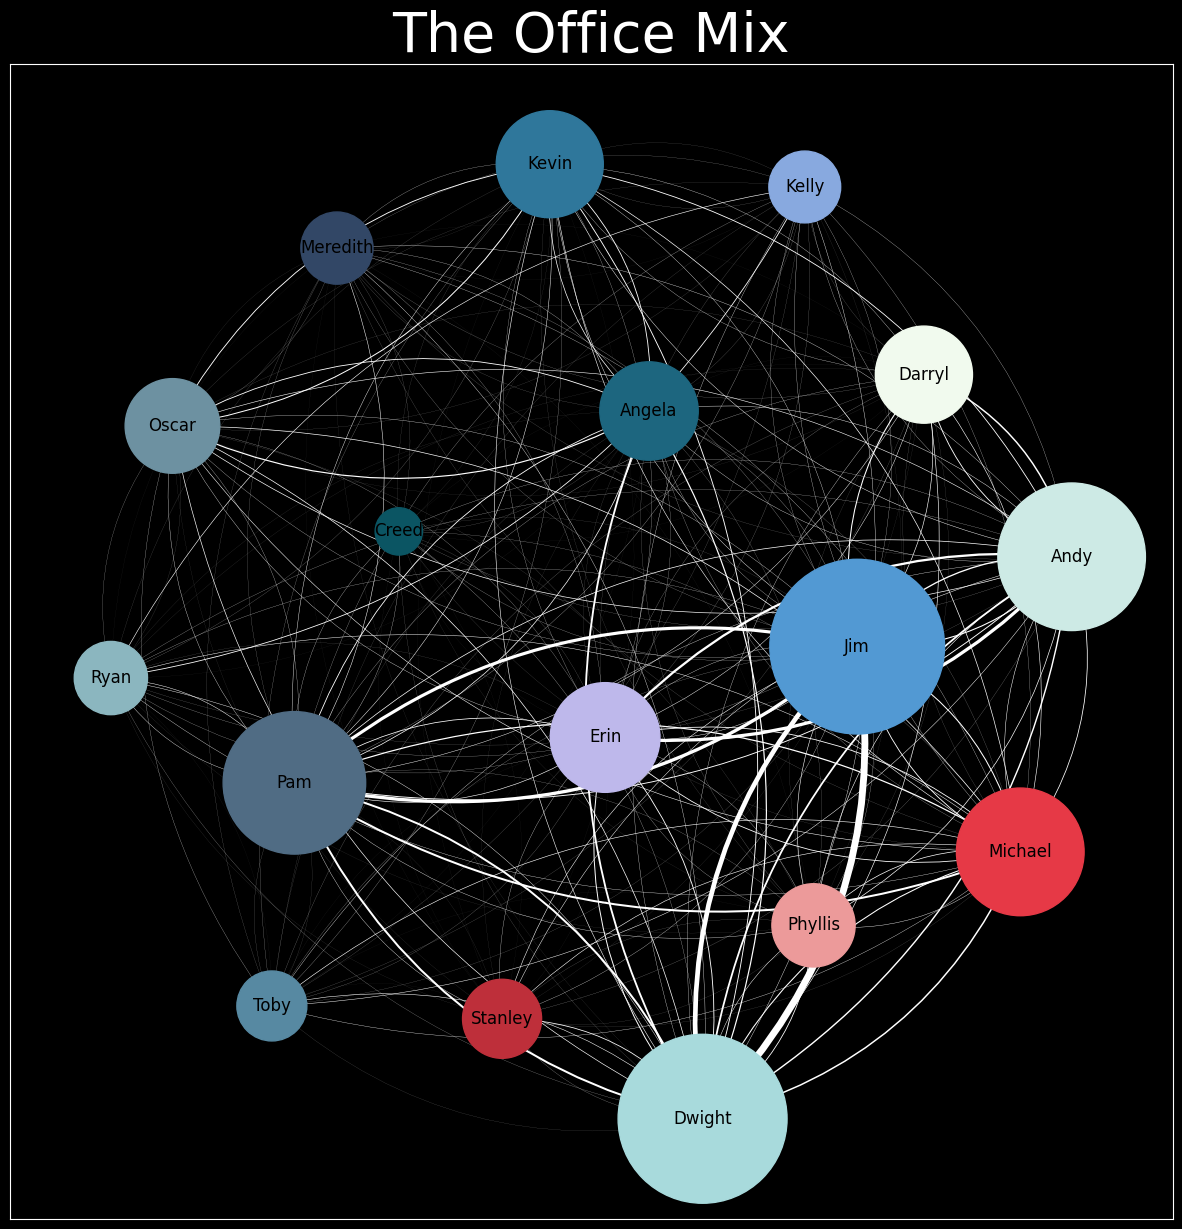

In [13]:
# Initializing Graph
plt.style.use('dark_background')

G = nx.MultiDiGraph()
edge_list = to_edge_list(completed_objs)
node_size=get_node_size(completed_objs)
G.add_edges_from(edge_list)

# Using Spring Layout
pos=nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(15,15))

# Drawing nodes
node_color = ['#be2f3a', '#e63946', '#ec9a9a', '#f1faee', '#cdeae5', '#a8dadc', '#8bb6bf', '#6d91a1', '#506c84', '#324766', '#beb8eb', '#88a9df', '#5299d3', '#2f779b', '#1d667f', '#0b5563', '#5789a2']
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, node_color=node_color, margins=0.05)
nx.draw_networkx_labels(G, pos, ax=ax, font_color='black')

# Drawing edges
width = nx.get_edge_attributes(G, 'w')
w = []
for wi in width.values():
    w.append(float(wi)/50)
arc_rad = 0.25
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edge_list, connectionstyle=f'arc3, rad = {arc_rad}', width=w, edge_color='white')

ax.set_facecolor('black')
ax.set_title("The Office Mix", fontdict={'fontsize': '40'})

plt.show()

### Sankey Diagram using Plotly

In [14]:
def get_label(chars):
    return list(chars) * 2

In [15]:
# Getting the top n characters whose names have been called out
def top_n(objs, n):
    zzz = get_node_size(objs)
    df = pd.DataFrame()
    df['Char'] = list(main_characters)
    df['Count'] = zzz
    df['Count'] = df['Count']/27
    df = df.astype({'Count': np.int16})
    l = list(df.sort_values(by='Count', ascending=False)[:n]['Char'])
    return l

In [16]:
# Creating the link dict for the Sankey diag
def get_link_dict(objs, n):
    chars = top_n(completed_objs, n)
    color_list = ['#e9d8a6','#e9d8a6','#e9d8a6','#e9d8a6','#e9d8a6','#e9d8a6','#e9d8a6',
    '#94d2bd','#94d2bd','#94d2bd','#94d2bd','#94d2bd','#94d2bd','#94d2bd', 
'#ee9b00','#ee9b00','#ee9b00','#ee9b00','#ee9b00','#ee9b00','#ee9b00',
'#86AF6E','#86AF6E','#86AF6E','#86AF6E','#86AF6E','#86AF6E','#86AF6E',
'#ae2012','#ae2012','#ae2012','#ae2012','#ae2012','#ae2012','#ae2012',
'#005f73','#005f73','#005f73','#005f73','#005f73','#005f73','#005f73', 
'#ca6702','#ca6702','#ca6702','#ca6702','#ca6702','#ca6702','#ca6702',
'#003946','#003946','#003946','#003946','#003946','#003946','#003946']

    links = [(char, key, obj.map[key])
             for obj in objs
             for char in chars
             if char == obj.name
             for key in obj.map.keys()
             if key in chars]
    
    link_dict = dict(
        source = [list(chars).index(link[0]) for link in links],
        target = [list(chars).index(link[1]) + len(chars) for link in links],
        value = [int(link[2]) for link in links],
        hovertemplate = '%{source.label} has uttered %{target.label}\'s name %{value} times.',
        color = color_list
    )

    return link_dict


In [17]:
# Creating the node dict for the Sankey diag
def get_node_dict(completed_objs, n):
    top_n_characters = top_n(completed_objs, n)
    node = dict(
      pad=0,
      thickness = 20,
      label = get_label(top_n_characters),
      color = "#808080"
    )
    return node

In [18]:
# Plotting for top 8 characters
n = 8

# Creating the Sankey plot
fig = go.Figure(data=[go.Sankey(
    node = get_node_dict(completed_objs, n),
    link = get_link_dict(completed_objs, n)
    )])

# Updating properties
fig.update_layout(
    autosize=False,
    width=1200,
    height=700,
    title_text='The Office Sankey',
    title_font=dict(size=30, color='black'),
    hovermode = 'x',
    font=dict(size = 15, color = 'black'),
    paper_bgcolor='#e8e8e8'
)
fig.show()

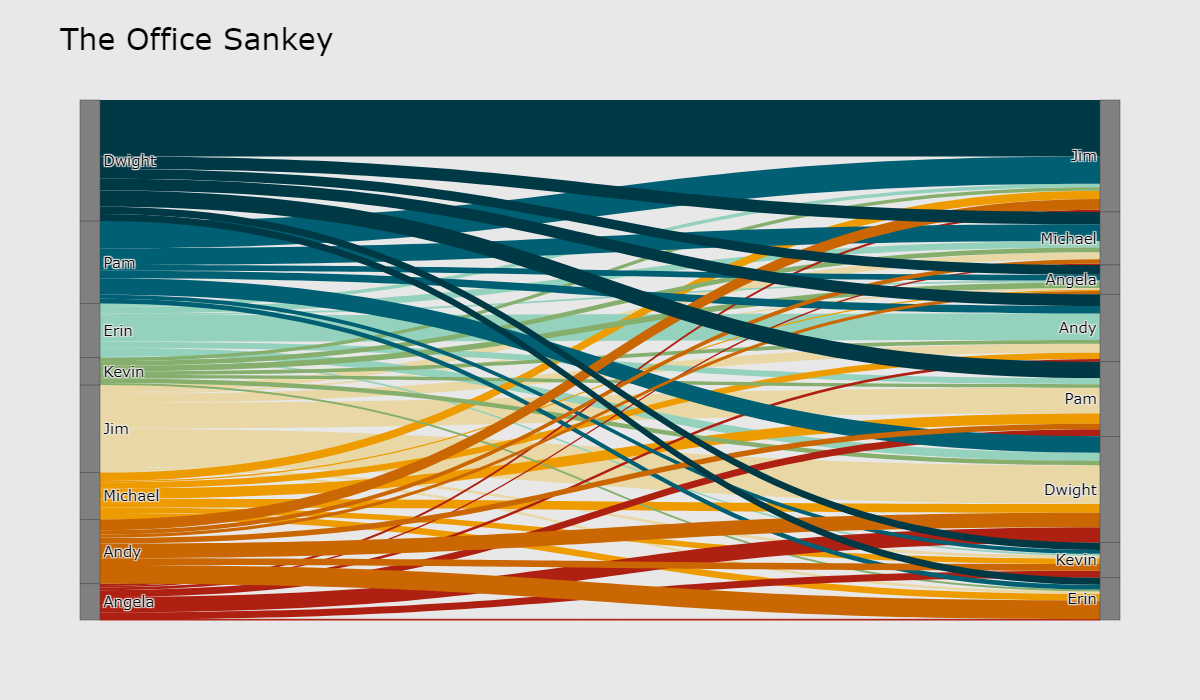

In [5]:
Image(filename="D:\Projects\Viz\Sankey.png", width = 1000, height=1000)

### HeatMap using Seaborn

In [19]:
# Creating the heatmap dict
def get_heatmap_dict(chars, objs):
    links = [(char, key, obj.map[key])
            for obj in objs
            for char in chars
            if char == obj.name
            for key in obj.map.keys()
            if key in chars]
    
    link_dict = dict(
        source = [link[0] for link in links],
        target = [link[1] for link in links],
        value = [int(link[2]) for link in links]
    )
    return link_dict

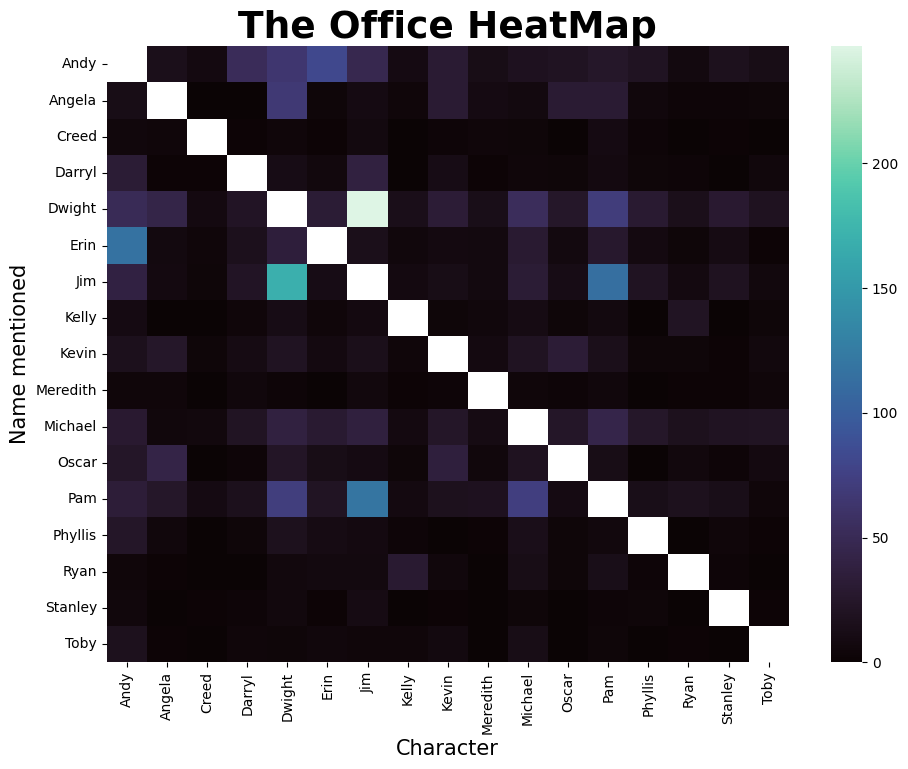

In [20]:
heatmap_dict = get_heatmap_dict(main_characters, completed_objs)

# Create a dataframe from the dict
df = pd.DataFrame(heatmap_dict, columns=heatmap_dict.keys())

# Create a pivot table with the data
pivot_table = df.pivot_table(values='value', index='source', columns='target')

plt.style.use('default')
plt.figure(figsize=(11,8))

# Create a heatmap
sns.heatmap(pivot_table, cmap='mako')

plt.title('The Office HeatMap', weight='bold').set_fontsize('27')
plt.xlabel('Character', fontsize=15)
plt.ylabel('Name mentioned', fontsize=15)

# Show the plot
plt.show()

### Chord Plot using d3Blocks

In [21]:
# Create the dataframe for the Chord Diag
def get_chord_df(chars, objs):
    diction = get_heatmap_dict(chars, objs)
    df = pd.DataFrame(diction, columns=diction.keys())
    df = df.rename(columns={'value': 'weight'})
    return df

In [22]:
# Initialize the block
d3 = D3Blocks(chart='Chord', frame=False)

# Load example data
df = get_chord_df(main_characters, completed_objs)

# Set properties
d3.set_node_properties(df, opacity=0.8, cmap='mako')
d3.set_edge_properties(df, color='source', opacity='source')
d3.show()

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [C:\Users\venka\AppData\Local\Temp\d3blocks\chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Convert to Dictionary.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [C:\Users\venka\AppData\Local\Temp\d3blocks\chord.html]
[d3blocks] >INFO> Open browser: C:\Users\venka\AppData\Local\Temp\d3blocks\chord.html


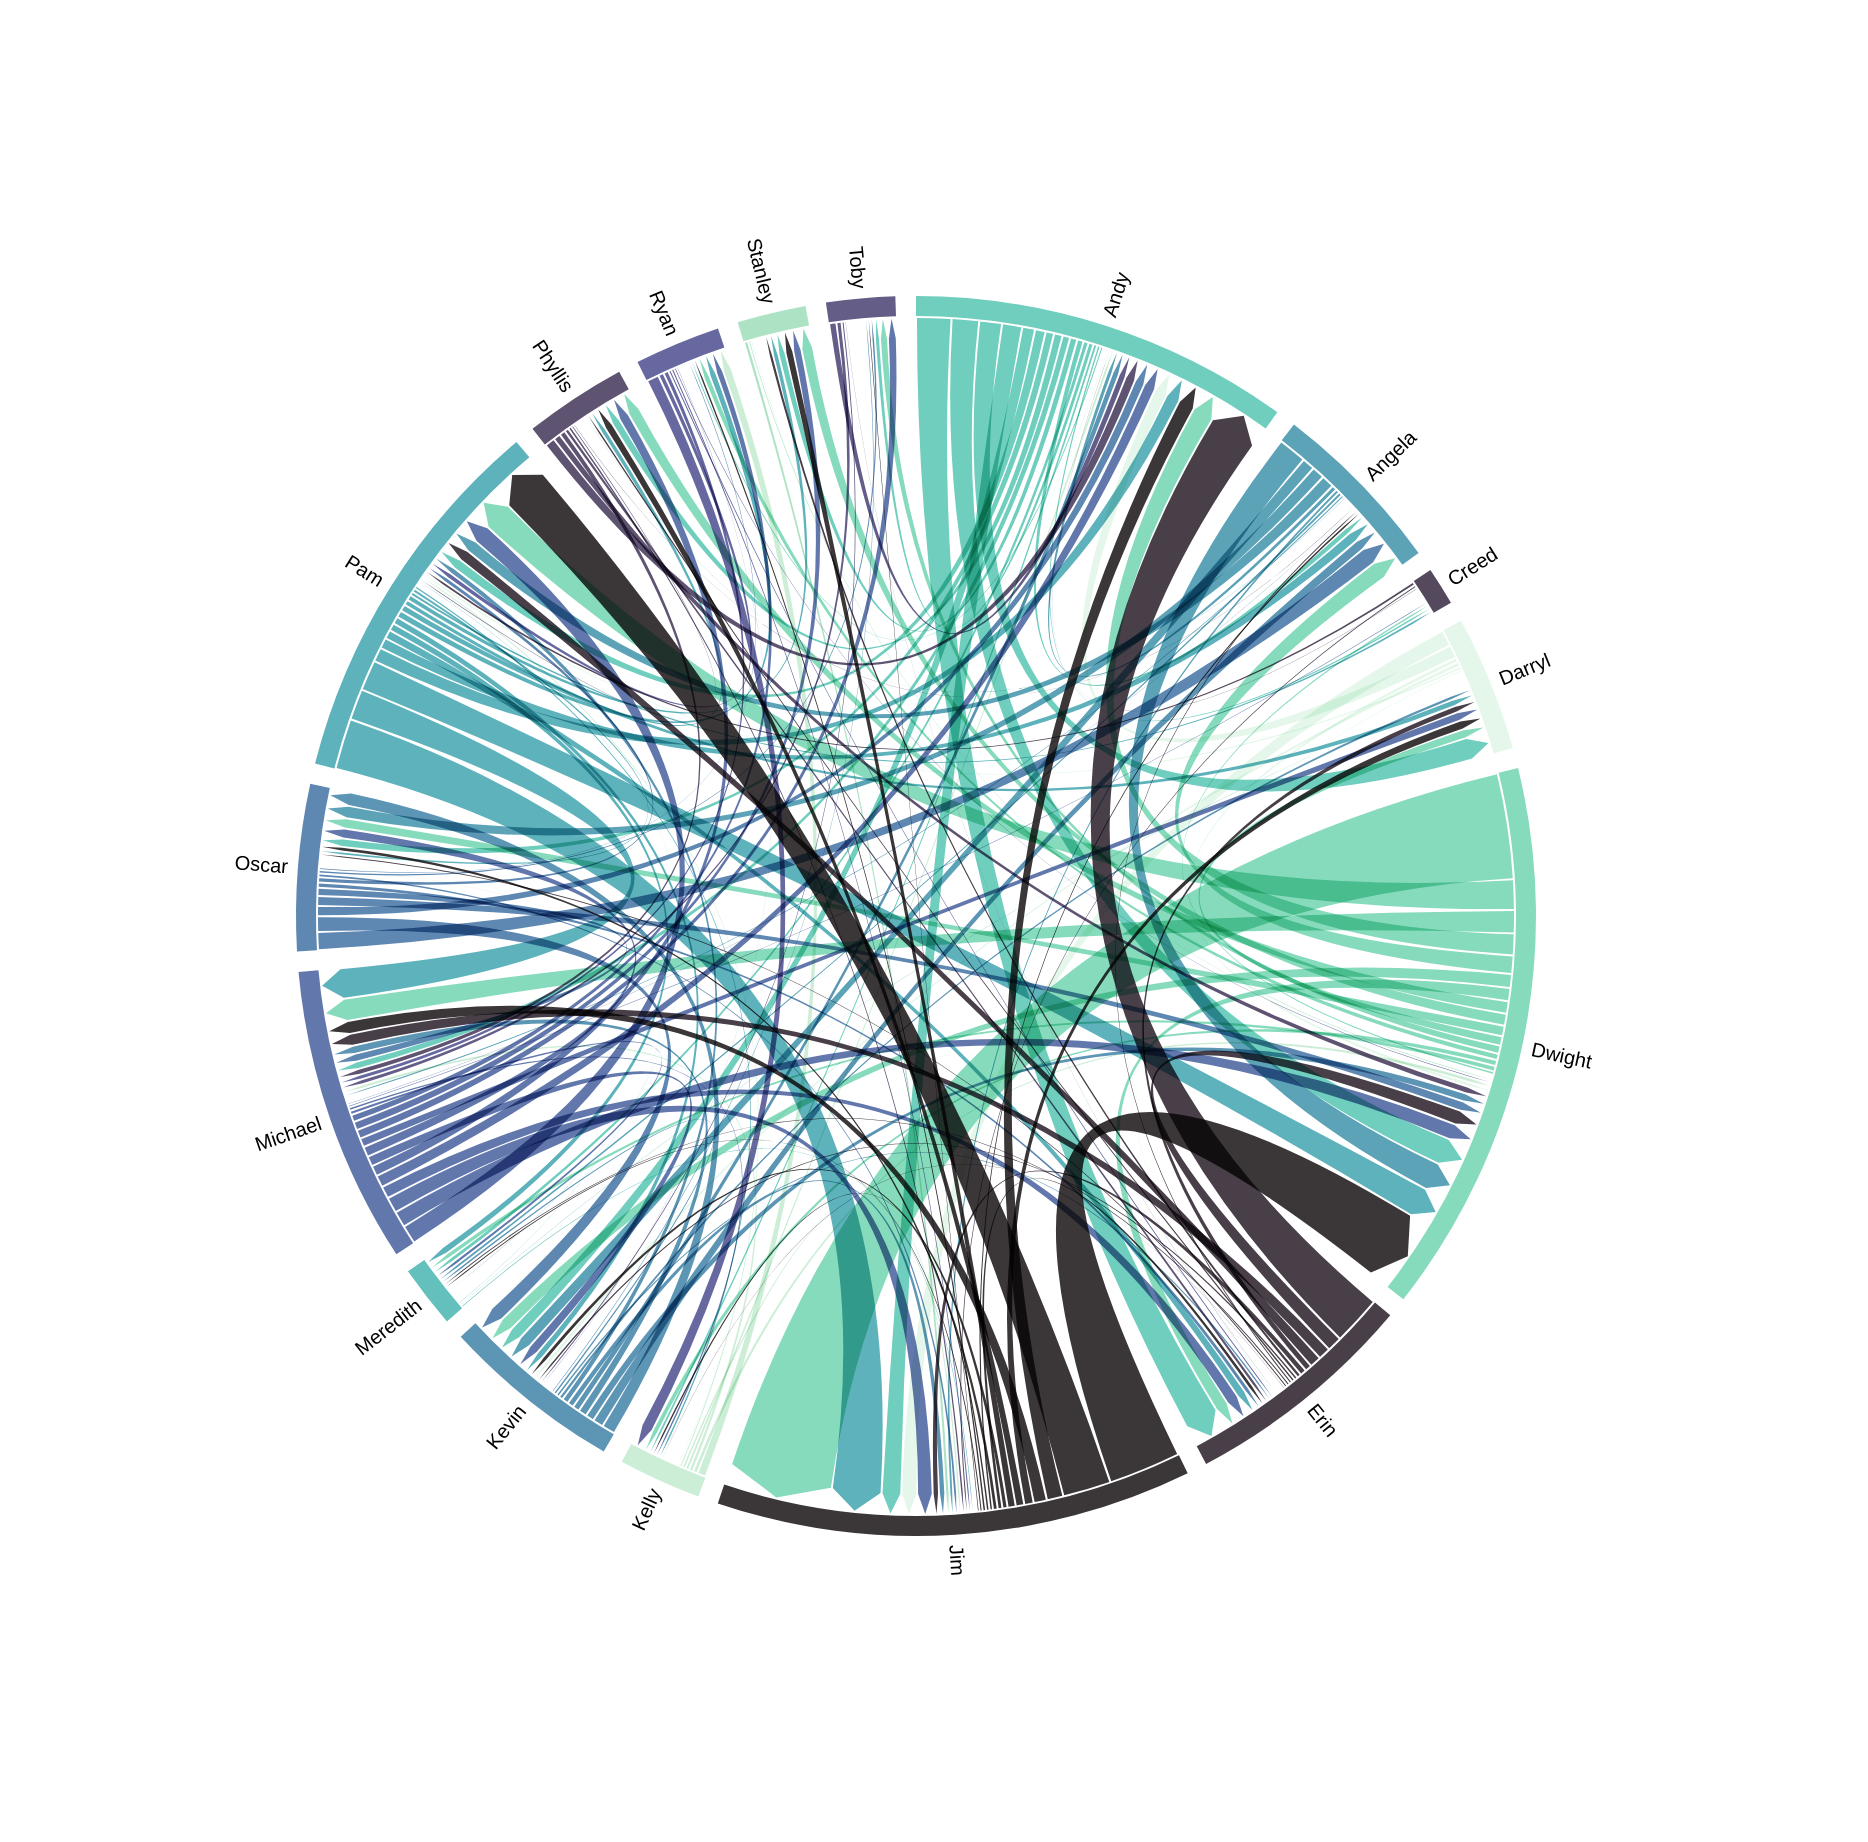

In [23]:
# Showing the image downloaded from the html generated
Image(filename="D:\Projects\Viz\Chord - D3blocks.png", width = 900, height=900)